<a href="https://colab.research.google.com/github/WVital2025/The-Approximation-Capability-of-Hypercomplex-Valued-Residual-Neural-Networks/blob/main/Regression_ResNet_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras.layers import Dense

2024-01-21 22:30:40.926392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 22:30:42.760494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 22:30:42.760586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 22:30:42.987072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 22:30:44.275797: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 22:30:44.303973: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
def ftrue(X):
    return np.stack([X[:,0]**2 - X[:,1]**2, X[:,0]**2+X[:,0]*X[:,1]+X[:,1]**2],1)

In [ ]:
# Create a meshgrid for x and y values
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute the corresponding z values using the function
Xtr = np.stack([X.flatten(), Y.flatten()],1)
ytr = ftrue(Xtr)
Xtr.shape,ytr.shape

((10000, 2), (10000, 2))

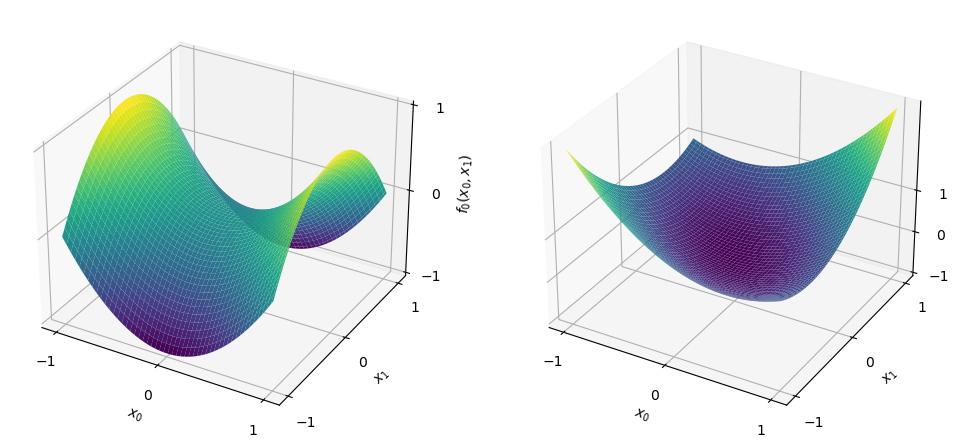

In [ ]:
# Create a meshgrid for x and y values
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

# Compute the corresponding z values using the function
Z = ftrue(np.stack([X[:], Y[:]],1))

# Create a 3D plot
fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(121, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z[:,0].reshape(100,100), cmap='viridis')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$f_0(x_0,x_1)$')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z[:,1].reshape(100,100), cmap='viridis')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$f_1(x_0,x_1)$')

plt.savefig("Figures2D/f_2D.pdf", bbox_inches='tight',pad_inches=0.4)
# Show the plot
plt.show()

In [ ]:
def NetPlot(net,Name=None):
    # Create a meshgrid for x and y values
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Compute the corresponding z values using the function
    Z = net.predict(np.stack([X.flatten(), Y.flatten()],1))

    # Create a 3D plot
    fig = plt.figure(figsize=(12,10))

    ax = fig.add_subplot(121, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z[:,0].reshape(100,100), cmap='viridis')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$f_0(x_0,x_1)$')

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(X, Y, Z[:,1].reshape(100,100), cmap='viridis')
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_zticks([-1, 0, 1])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$f_1(x_0,x_1)$')

    if Name is not None:
        plt.savefig("Figures2D/"+Name+".pdf", bbox_inches='tight',pad_inches=0.4)

    # Show the plot
    plt.show()

# V-Dense Layers

In [ ]:
class V_Dense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 kernel_initializer="glorot_uniform",
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_Dense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer=kernel_initializer
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        self.W = self.add_weight(
            shape=(input_dim, self.units,self.algdim),
            initializer=self.kernel_initializer,
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [ ]:
class V_RealDense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 kernel_initializer="glorot_uniform",
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(V_RealDense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer=kernel_initializer
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units),
            initializer=self.kernel_initializer,
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.experimental.numpy.kron(np.eye(self.algdim, dtype = np.float32),self.W)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

# Hyper-parameters

In [ ]:
Nhidden = 34
Nepochs = 500
opt_method = 'adam'

In [ ]:
def MeanAbs(y_true,y_pred):
    return tf.reduce_mean(tf.math.sqrt(tf.reduce_sum(tf.math.square(y_true-y_pred),axis=1)))

# Real-valued ResNet

In [ ]:
# Define the residual block.

class ResNetBlock(kr.layers.Layer):
    def __init__(self):
        super(ResNetBlock, self).__init__()

    def build(self, input_shape):
        self.Ub = kr.layers.Dense(1, activation='relu',use_bias = True,
                                  kernel_initializer=kr.initializers.RandomUniform(minval=-1.0, maxval=1.0))
        self.V = kr.layers.Dense(input_shape[-1], activation=None, use_bias=False,
                                kernel_initializer=kr.initializers.RandomUniform(minval=-1.0, maxval=1.0))

    def call(self, inputs):
        return inputs + self.V(self.Ub(inputs))

In [ ]:
kr.backend.clear_session()

Layers = [ResNetBlock() for i in range(Nhidden)]
Layers.append(kr.layers.Dense(2, activation=None, use_bias = False))

RealResNet = kr.Sequential(Layers)

RealResNet.compile(optimizer=opt_method,loss='mse',metrics=[MeanAbs])
h_Real = RealResNet.fit(Xtr,ytr, epochs=Nepochs, verbose = 1, batch_size=256) #, callbacks=[callback])

RealResNet.summary()

Epoch 1/500
40/40 [==============================] - 8s 5ms/step - loss: 0.6824 - MeanAbs: 0.8714
Epoch 2/500
40/40 [==============================] - 0s 4ms/step - loss: 0.4114 - MeanAbs: 0.7000
Epoch 3/500
40/40 [==============================] - 0s 5ms/step - loss: 0.3200 - MeanAbs: 0.6218
Epoch 4/500
40/40 [==============================] - 0s 5ms/step - loss: 0.2401 - MeanAbs: 0.5482
Epoch 5/500
40/40 [==============================] - 0s 5ms/step - loss: 0.1660 - MeanAbs: 0.4760
Epoch 6/500
40/40 [==============================] - 0s 5ms/step - loss: 0.1359 - MeanAbs: 0.4340
Epoch 7/500
40/40 [==============================] - 0s 5ms/step - loss: 0.1221 - MeanAbs: 0.4104
Epoch 8/500
40/40 [==============================] - 0s 5ms/step - loss: 0.1135 - MeanAbs: 0.3928
Epoch 9/500
40/40 [==============================] - 0s 5ms/step - loss: 0.1080 - MeanAbs: 0.3864
Epoch 10/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1051 - MeanAbs: 0.3812
Epoch 11/500
40/40 

40/40 [==============================] - 0s 5ms/step - loss: 0.0556 - MeanAbs: 0.2530
Epoch 84/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0540 - MeanAbs: 0.2487
Epoch 85/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0543 - MeanAbs: 0.2508
Epoch 86/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0531 - MeanAbs: 0.2432
Epoch 87/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0520 - MeanAbs: 0.2409
Epoch 88/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0503 - MeanAbs: 0.2336
Epoch 89/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0495 - MeanAbs: 0.2326
Epoch 90/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0485 - MeanAbs: 0.2302
Epoch 91/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0476 - MeanAbs: 0.2259
Epoch 92/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0461 - MeanAbs: 0.2218
Epoch 93/500
40/40 [===

40/40 [==============================] - 0s 5ms/step - loss: 0.0017 - MeanAbs: 0.0504
Epoch 166/500
40/40 [==============================] - 0s 4ms/step - loss: 0.0016 - MeanAbs: 0.0502
Epoch 167/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0016 - MeanAbs: 0.0492
Epoch 168/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0016 - MeanAbs: 0.0494
Epoch 169/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0016 - MeanAbs: 0.0490
Epoch 170/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0016 - MeanAbs: 0.0491
Epoch 171/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0015 - MeanAbs: 0.0484
Epoch 172/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0017 - MeanAbs: 0.0504
Epoch 173/500
40/40 [==============================] - 0s 4ms/step - loss: 0.0015 - MeanAbs: 0.0479
Epoch 174/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0015 - MeanAbs: 0.0482
Epoch 175/500


40/40 [==============================] - 0s 4ms/step - loss: 0.0011 - MeanAbs: 0.0413
Epoch 248/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0012 - MeanAbs: 0.0419
Epoch 249/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - MeanAbs: 0.0393
Epoch 250/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - MeanAbs: 0.0393
Epoch 251/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - MeanAbs: 0.0398
Epoch 252/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0011 - MeanAbs: 0.0405
Epoch 253/500
40/40 [==============================] - 0s 4ms/step - loss: 9.9249e-04 - MeanAbs: 0.0391
Epoch 254/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - MeanAbs: 0.0395
Epoch 255/500
40/40 [==============================] - 0s 4ms/step - loss: 0.0010 - MeanAbs: 0.0390
Epoch 256/500
40/40 [==============================] - 0s 5ms/step - loss: 0.0010 - MeanAbs: 0.0392
Epoch 257/

40/40 [==============================] - 0s 5ms/step - loss: 6.0633e-04 - MeanAbs: 0.0305
Epoch 327/500
40/40 [==============================] - 0s 5ms/step - loss: 6.3079e-04 - MeanAbs: 0.0309
Epoch 328/500
40/40 [==============================] - 0s 5ms/step - loss: 6.3605e-04 - MeanAbs: 0.0310
Epoch 329/500
40/40 [==============================] - 0s 4ms/step - loss: 6.8294e-04 - MeanAbs: 0.0323
Epoch 330/500
40/40 [==============================] - 0s 5ms/step - loss: 6.4888e-04 - MeanAbs: 0.0313
Epoch 331/500
40/40 [==============================] - 0s 5ms/step - loss: 6.1135e-04 - MeanAbs: 0.0306
Epoch 332/500
40/40 [==============================] - 0s 4ms/step - loss: 5.9180e-04 - MeanAbs: 0.0299
Epoch 333/500
40/40 [==============================] - 0s 4ms/step - loss: 5.7917e-04 - MeanAbs: 0.0297
Epoch 334/500
40/40 [==============================] - 0s 4ms/step - loss: 5.8791e-04 - MeanAbs: 0.0300
Epoch 335/500
40/40 [==============================] - 0s 4ms/step - loss: 6.1

40/40 [==============================] - 0s 5ms/step - loss: 3.3335e-04 - MeanAbs: 0.0223
Epoch 405/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0245e-04 - MeanAbs: 0.0215
Epoch 406/500
40/40 [==============================] - 0s 5ms/step - loss: 3.2260e-04 - MeanAbs: 0.0221
Epoch 407/500
40/40 [==============================] - 0s 5ms/step - loss: 3.1867e-04 - MeanAbs: 0.0219
Epoch 408/500
40/40 [==============================] - 0s 5ms/step - loss: 3.3599e-04 - MeanAbs: 0.0224
Epoch 409/500
40/40 [==============================] - 0s 4ms/step - loss: 3.0159e-04 - MeanAbs: 0.0214
Epoch 410/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0033e-04 - MeanAbs: 0.0213
Epoch 411/500
40/40 [==============================] - 0s 5ms/step - loss: 3.6113e-04 - MeanAbs: 0.0231
Epoch 412/500
40/40 [==============================] - 0s 5ms/step - loss: 3.1920e-04 - MeanAbs: 0.0219
Epoch 413/500
40/40 [==============================] - 0s 5ms/step - loss: 2.8

40/40 [==============================] - 0s 5ms/step - loss: 2.9081e-04 - MeanAbs: 0.0210
Epoch 483/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5779e-04 - MeanAbs: 0.0199
Epoch 484/500
40/40 [==============================] - 0s 5ms/step - loss: 3.0401e-04 - MeanAbs: 0.0215
Epoch 485/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7041e-04 - MeanAbs: 0.0203
Epoch 486/500
40/40 [==============================] - 0s 5ms/step - loss: 2.6899e-04 - MeanAbs: 0.0203
Epoch 487/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7833e-04 - MeanAbs: 0.0207
Epoch 488/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7055e-04 - MeanAbs: 0.0203
Epoch 489/500
40/40 [==============================] - 0s 5ms/step - loss: 2.7683e-04 - MeanAbs: 0.0204
Epoch 490/500
40/40 [==============================] - 0s 5ms/step - loss: 2.5241e-04 - MeanAbs: 0.0196
Epoch 491/500
40/40 [==============================] - 0s 5ms/step - loss: 2.9

                                                                 
 res_net_block_31 (ResNetBl  (None, 2)                 5         
 ock)                                                            
                                                                 
 res_net_block_32 (ResNetBl  (None, 2)                 5         
 ock)                                                            
                                                                 
 res_net_block_33 (ResNetBl  (None, 2)                 5         
 ock)                                                            
                                                                 
 dense (Dense)               (None, 2)                 4         
                                                                 
Total params: 174 (696.00 Byte)
Trainable params: 174 (696.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Loss: 2.84e-04
Error: 2.08e-02


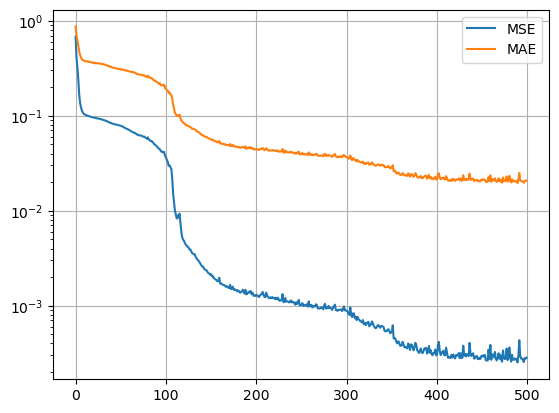

In [ ]:
# plt.figure(figsize=(8,6))
plt.semilogy(h_Real.history['loss'],label="MSE")
plt.semilogy(h_Real.history['MeanAbs'],label="MAE")
plt.grid()
plt.legend()

print("Loss: %2.2e" % h_Real.history['loss'][-1])
print("Error: %2.2e" % h_Real.history['MeanAbs'][-1])

313/313 [==============================] - 1s 2ms/step


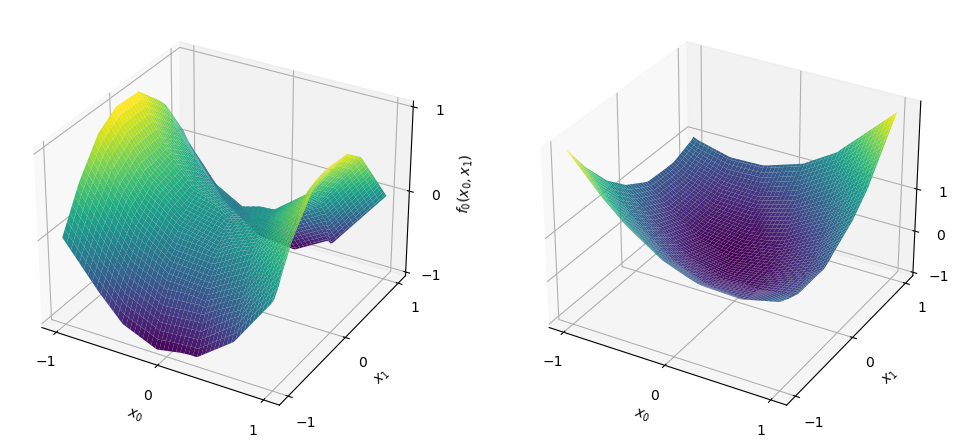

In [ ]:
NetPlot(RealResNet,Name="R_ResNet2D")

# V-Residual Block

In [ ]:
class V_ResNetBlock(kr.layers.Layer):
    def __init__(self,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        super(V_ResNetBlock, self).__init__()
        self.algebra = algebra

    def build(self, input_shape):
        self.Ub = V_Dense(1, activation='relu', algebra=self.algebra,
                        kernel_initializer=kr.initializers.RandomUniform(minval=-1.0, maxval=1.0))
        self.V = V_RealDense(input_shape[-1]//2, activation=None, use_bias=False,
                        algebra=self.algebra,
                        kernel_initializer=kr.initializers.RandomUniform(minval=-1.0, maxval=1.0))

    def call(self, inputs):
        return inputs + self.V(self.Ub(inputs))

In [ ]:
def EvalV_ResNet(
        algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1),
        Name = "C_ResNet2D",
        verbose = 0):

    print("Algebra:")
    print(algebra[:,:,0])
    print(algebra[:,:,1])

    kr.backend.clear_session()

    Layers = [V_ResNetBlock(algebra = algebra) for i in range(Nhidden)]
    Layers.append(V_RealDense(1, algebra = algebra, activation=None, use_bias = False))

    V_ResNet = kr.Sequential(Layers)

    V_ResNet.compile(optimizer=opt_method,loss='mse',metrics=[MeanAbs])
    hist = V_ResNet.fit(Xtr,ytr, epochs=Nepochs, verbose = verbose, batch_size=256) #, callbacks=[callback])

    if verbose>0:
        print(V_ResNet.summary())

    NetPlot(V_ResNet,Name=Name)

    return V_ResNet, hist

# NonDegenerate Algebra (A)

In [ ]:
AlgebraA = np.stack([np.array([[1.0,0.0],[0.0,1.0]]),np.array([[1.0,0.0],[0.0,1.0]])],axis=-1)
AlgebraA[:,:,0],AlgebraA[:,:,1]

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]))

Algebra:
[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
313/313 [==============================] - 3s 2ms/step


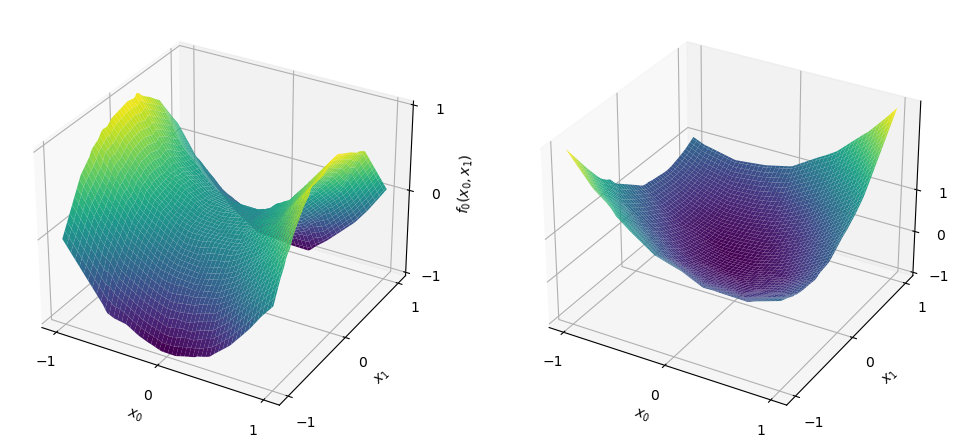

In [ ]:
A_ResNet,A_hist = EvalV_ResNet(algebra = AlgebraA,Name="A_ResNet2D",verbose=0)

# Degenerate Algebra (B)

In [ ]:
AlgebraB = np.stack([np.array([[1.0,0.0],[0.0,1.0]]),np.array([[1.0,1.0],[1.0,1.0]])],axis=-1)
AlgebraB[:,:,0],AlgebraB[:,:,1]

(array([[1., 0.],
        [0., 1.]]),
 array([[1., 1.],
        [1., 1.]]))

Algebra:
[[1. 0.]
 [0. 1.]]
[[1. 1.]
 [1. 1.]]
313/313 [==============================] - 3s 2ms/step


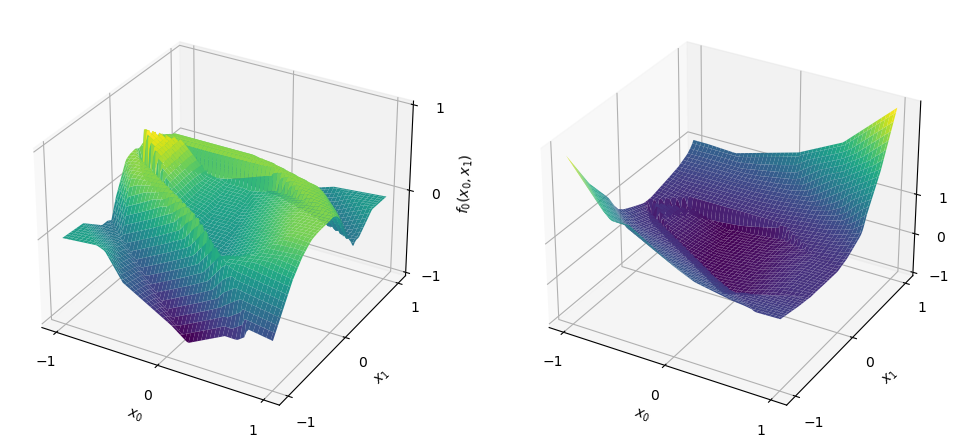

In [ ]:
B_ResNet,B_hist = EvalV_ResNet(algebra = AlgebraB,Name="B_ResNet2D",verbose=0)

# Complex-valued

In [ ]:
ComplexNumbers = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
ComplexNumbers[:,:,0],ComplexNumbers[:,:,1]

(array([[ 1.,  0.],
        [ 0., -1.]]),
 array([[0., 1.],
        [1., 0.]]))

Algebra:
[[ 1.  0.]
 [ 0. -1.]]
[[0. 1.]
 [1. 0.]]
313/313 [==============================] - 3s 2ms/step


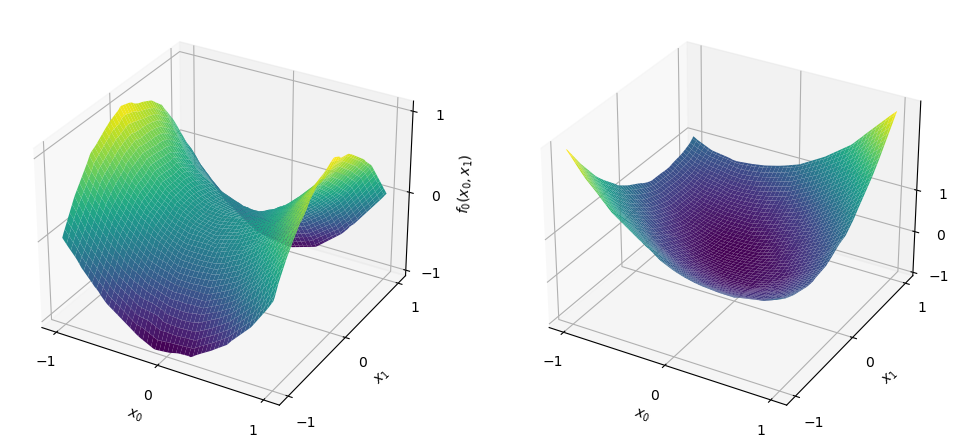

In [ ]:
C_ResNet,C_hist = EvalV_ResNet(algebra = ComplexNumbers, Name="C_ResNet2D", verbose=0)

# Dual Numbers

In [ ]:
DualNumbers = np.stack([np.array([[1.0,0.0],[0.0,0.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
DualNumbers[:,:,0],DualNumbers[:,:,1]

(array([[1., 0.],
        [0., 0.]]),
 array([[0., 1.],
        [1., 0.]]))

Algebra:
[[1. 0.]
 [0. 0.]]
[[0. 1.]
 [1. 0.]]
313/313 [==============================] - 3s 2ms/step


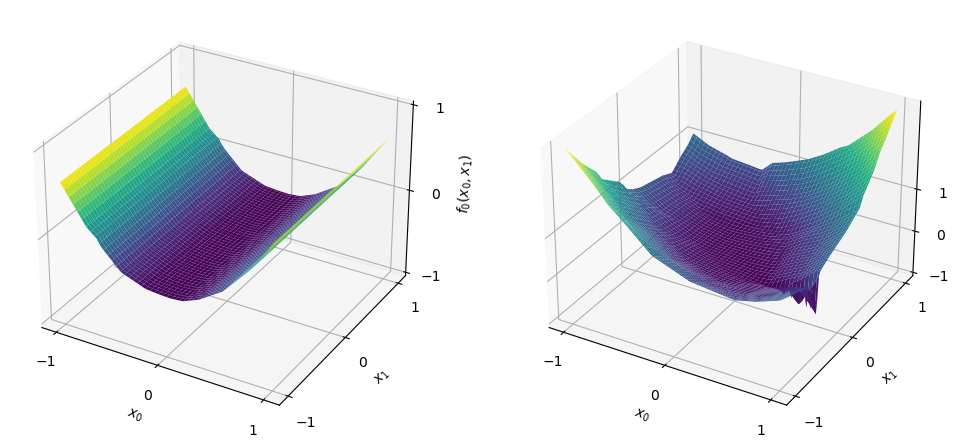

In [ ]:
D_ResNet,D_hist = EvalV_ResNet(algebra = DualNumbers, Name="D_ResNet2D", verbose=0)

# Algebra E (Isomorphic to dual numbers)

In [ ]:
AlgebraE = np.stack([np.array([[3.0/2.0,1.0/2.0],[1.0/2.0,-1.0/2.0]]),np.array([[-1.0/2.0,1.0/2.0],[1.0/2.0,3.0/2.0]])],axis=-1)
AlgebraE[:,:,0],AlgebraE[:,:,1]

(array([[ 1.5,  0.5],
        [ 0.5, -0.5]]),
 array([[-0.5,  0.5],
        [ 0.5,  1.5]]))

Algebra:
[[ 1.5  0.5]
 [ 0.5 -0.5]]
[[-0.5  0.5]
 [ 0.5  1.5]]
313/313 [==============================] - 3s 2ms/step


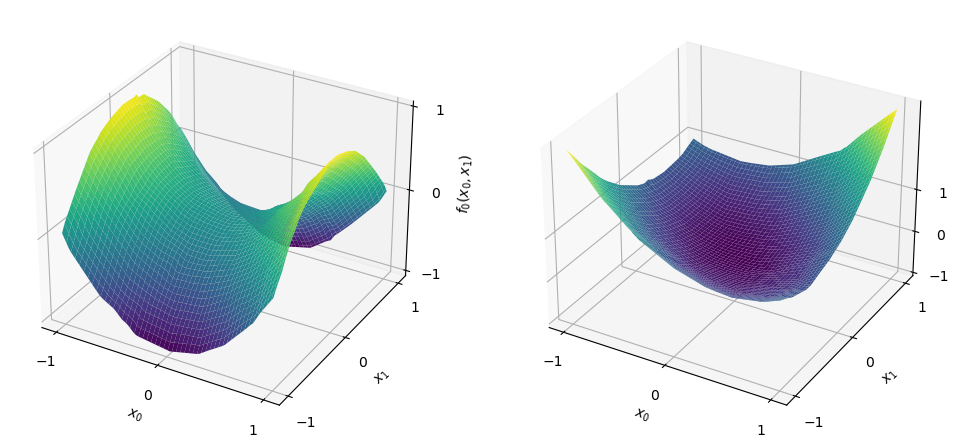

In [ ]:
E_ResNet,E_hist = EvalV_ResNet(algebra = AlgebraE, Name="E_ResNet2D", verbose=0)

# Plots and Errors

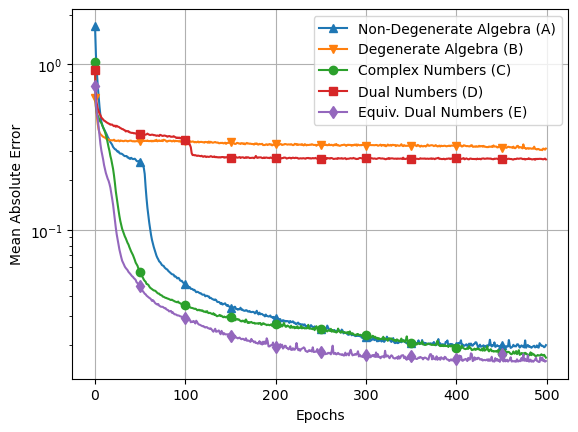

In [ ]:
plt.semilogy(A_hist.history['MeanAbs'],'-^',label="Non-Degenerate Algebra (A)",markevery=50)
plt.semilogy(B_hist.history['MeanAbs'],'-v',label="Degenerate Algebra (B)",markevery=50)
plt.semilogy(C_hist.history['MeanAbs'],'-o',label="Complex Numbers (C)",markevery=50)
plt.semilogy(D_hist.history['MeanAbs'],'-s',label="Dual Numbers (D)",markevery=50)
plt.semilogy(E_hist.history['MeanAbs'],'-d',label="Equiv. Dual Numbers (E)",markevery=50)
plt.legend()
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")

plt.savefig("Figures2D/Experiment_2D.pdf")

In [ ]:
print("A: %2.2e" % A_hist.history['MeanAbs'][-1])
print("B: %2.2e" % B_hist.history['MeanAbs'][-1])
print("C: %2.2e" % C_hist.history['MeanAbs'][-1])
print("D: %2.2e" % D_hist.history['MeanAbs'][-1])
print("E: %2.2e" % E_hist.history['MeanAbs'][-1])

A: 2.01e-02
B: 3.10e-01
C: 1.69e-02
D: 2.67e-01
E: 1.61e-02
